In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import math

In [15]:
test = pd.read_csv('..\\Steam Data\\steam_top_games_03-13-2025_19-11-34.csv',converters={'Genres':pd.eval,'Tags':pd.eval})


In [16]:
tags_expanded = pd.DataFrame(test['Tags'].tolist(), index=test.index).stack().reset_index(level=1, drop=True)
tags_expanded

0               FPS
0           Shooter
0       Multiplayer
0       Competitive
0            Action
           ...     
174       Utilities
174           Indie
174           Retro
174            Cute
174    Singleplayer
Length: 3386, dtype: object

In [17]:
tag_dummies = pd.get_dummies(tags_expanded).groupby(level=0).sum()
tag_dummies

,1980s,1990's,2D,2D Fighter,2D Platformer,3D,3D Fighter,3D Platformer,3D Vision,4 Player Local,...,Walking Simulator,War,Wargame,Warhammer 40K,Web Publishing,Western,World War I,World War II,Zombies,eSports
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
171,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
172,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
173,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:

def calc_sucess_score(gamedata):
    recent_review_score = gamedata['Recent Review Score']
    recent_review_count = gamedata['Recent Review Count']

    all_review_score = gamedata['All Review Score']
    all_review_count = gamedata['All Review Count']

    player_hours = gamedata['Player Hours']
    days_since_release = gamedata['Days Since Release']

    current_players = gamedata['Current']
    peak_players = gamedata['Peak']
    success_score = (
        (recent_review_score * math.log(recent_review_count)) +
        (all_review_score * math.log(all_review_count)) *.1 +
        (current_players/peak_players )+
        (math.log(player_hours)/days_since_release) +
        (math.log(days_since_release)/math.log(current_players))+ 
        (recent_review_count/all_review_count)
    )

    return(math.log(success_score))

In [98]:
from sklearn.metrics import mean_squared_error, r2_score
test['Popularity'] = test.apply(calc_sucess_score, axis=1)
test = test.dropna(subset=['Tags','Popularity'])
test_with_tags = pd.concat([test, tag_dummies], axis=1).dropna()
X = test_with_tags.drop(columns=['Game','Genres','Tags','Popularity','App ID','Release Date','Rank','Days Since Release','All Review Score','All Review Count','Recent Review Score','Recent Review Count','Current','Peak','Player Hours'])

y = test_with_tags['Popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = RandomForestRegressor(n_estimators=200, random_state=42,min_samples_split=2)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean squared Error: {mse}")
print(f"R2 Score: {r2}")

Mean squared Error: 0.0353288350346632
R2 Score: 0.428712708999085


In [35]:
test['Popularity'] = test.apply(calc_sucess_score, axis=1)
test = test.dropna(subset=['Tags','Popularity'])
test

,Rank,Game,Current,Peak,App ID,Player Hours,Genres,Release Date,Days Since Release,Tags,Recent Review Score,Recent Review Count,All Review Score,All Review Count,Popularity
0,1.0,Counter-Strike 2,796228,1783434,730,733041715,"[Action, Free To Play]","Aug 21, 2012",4587.0,"[FPS, Shooter, Multiplayer, Competitive, Actio...",8.0,96943.0,8.0,8638233.0,18.110128
1,2.0,Dota 2,314523,708043,570,300742579,"[Action, Strategy, Free To Play]","Jul 9, 2013",4265.0,"[Free to Play, MOBA, Multiplayer, Strategy, eS...",8.0,29640.0,8.0,2452879.0,17.219180
2,3.0,Monster Hunter Wilds,224689,1179869,2246340,118141194,"[Action, Adventure, RPG]","Feb 27, 2025",14.0,"[Hunting, Action, Multiplayer, Online Co-Op, C...",5.0,97373.0,5.0,97373.0,16.284806
3,4.0,Marvel Rivals,174695,437272,2767030,141302360,"[Action, Free To Play]","Dec 5, 2024",98.0,"[Free to Play, Multiplayer, Hero Shooter, Thir...",6.0,37808.0,8.0,244346.0,16.463828
4,5.0,PUBG: BATTLEGROUNDS,120626,905767,578080,234437691,"[Action, Adventure, Massively Multiplayer, Fre...","Dec 21, 2017",2639.0,"[Survival, Shooter, Battle Royale, Multiplayer...",5.0,18182.0,5.0,2515651.0,16.970115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,171.0,Among Us,4963,12182,945360,3304682,[Casual],"Nov 16, 2018",2309.0,"[Multiplayer, Social Deduction, Online Co-Op, ...",8.0,2371.0,8.0,613736.0,12.708278
171,172.0,The Forest,4909,12734,242760,4437366,"[Action, Adventure, Indie, Simulation]","Apr 30, 2018",2509.0,"[Open World Survival Craft, Survival, Open Wor...",9.0,5182.0,9.0,524010.0,13.002997
172,173.0,Black Myth: Wukong,4829,52688,2358720,14773884,"[Action, Adventure, RPG]","Aug 19, 2024",206.0,"[Mythology, Action RPG, Action, Souls-like, RP...",8.0,6253.0,9.0,825719.0,14.205789
173,174.0,Victoria 3,4744,8530,529340,3729759,"[Simulation, Strategy]","Oct 25, 2022",870.0,"[Grand Strategy, Historical, Economy, Politica...",6.0,20.0,5.0,32950.0,12.829276


In [36]:
test_with_tags = pd.concat([test, tag_dummies], axis=1).dropna()
test_with_tags

,Rank,Game,Current,Peak,App ID,Player Hours,Genres,Release Date,Days Since Release,Tags,...,Walking Simulator,War,Wargame,Warhammer 40K,Web Publishing,Western,World War I,World War II,Zombies,eSports
0,1.0,Counter-Strike 2,796228,1783434,730,733041715,"[Action, Free To Play]","Aug 21, 2012",4587.0,"[FPS, Shooter, Multiplayer, Competitive, Actio...",...,0,1,0,0,0,0,0,0,0,1
1,2.0,Dota 2,314523,708043,570,300742579,"[Action, Strategy, Free To Play]","Jul 9, 2013",4265.0,"[Free to Play, MOBA, Multiplayer, Strategy, eS...",...,0,0,0,0,0,0,0,0,0,1
2,3.0,Monster Hunter Wilds,224689,1179869,2246340,118141194,"[Action, Adventure, RPG]","Feb 27, 2025",14.0,"[Hunting, Action, Multiplayer, Online Co-Op, C...",...,0,0,0,0,0,0,0,0,0,0
3,4.0,Marvel Rivals,174695,437272,2767030,141302360,"[Action, Free To Play]","Dec 5, 2024",98.0,"[Free to Play, Multiplayer, Hero Shooter, Thir...",...,0,0,0,0,0,0,0,0,0,0
4,5.0,PUBG: BATTLEGROUNDS,120626,905767,578080,234437691,"[Action, Adventure, Massively Multiplayer, Fre...","Dec 21, 2017",2639.0,"[Survival, Shooter, Battle Royale, Multiplayer...",...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,171.0,Among Us,4963,12182,945360,3304682,[Casual],"Nov 16, 2018",2309.0,"[Multiplayer, Social Deduction, Online Co-Op, ...",...,0,0,0,0,0,0,0,0,0,0
171,172.0,The Forest,4909,12734,242760,4437366,"[Action, Adventure, Indie, Simulation]","Apr 30, 2018",2509.0,"[Open World Survival Craft, Survival, Open Wor...",...,0,0,0,0,0,0,0,0,1,0
172,173.0,Black Myth: Wukong,4829,52688,2358720,14773884,"[Action, Adventure, RPG]","Aug 19, 2024",206.0,"[Mythology, Action RPG, Action, Souls-like, RP...",...,0,0,0,0,0,0,0,0,0,0
173,174.0,Victoria 3,4744,8530,529340,3729759,"[Simulation, Strategy]","Oct 25, 2022",870.0,"[Grand Strategy, Historical, Economy, Politica...",...,0,0,0,0,0,0,0,0,0,0


In [37]:
X = test_with_tags.drop(columns=['Game','Genres','Tags','Popularity','App ID','Release Date','Rank','Days Since Release','All Review Score','All Review Count','Recent Review Score','Recent Review Count','Current','Peak','Player Hours'])

y = test_with_tags['Popularity']
X

,1980s,1990's,2D,2D Fighter,2D Platformer,3D,3D Fighter,3D Platformer,3D Vision,4 Player Local,...,Walking Simulator,War,Wargame,Warhammer 40K,Web Publishing,Western,World War I,World War II,Zombies,eSports
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
171,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
172,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
173,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [39]:
X_train

,1980s,1990's,2D,2D Fighter,2D Platformer,3D,3D Fighter,3D Platformer,3D Vision,4 Player Local,...,Walking Simulator,War,Wargame,Warhammer 40K,Web Publishing,Western,World War I,World War II,Zombies,eSports
156,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
138,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
149,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
52,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
128,0,0,0,0,0,1,0,0,0,0,...,0,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
108,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
93,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [82]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean squared Error: {mse}")
print(f"R2 Score: {r2}")

Mean squared Error: 0.036002774464652214
R2 Score: 0.4247064816837557


In [97]:
# Get the feature importances
importances = model.feature_importances_

# Create a DataFrame with the feature importances
feature_importances = pd.DataFrame({
    'Tag': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
feature_importances.to_csv('feature_importances_03_08.csv')
# Display the most important tags
print(feature_importances.head(30))


                         Tag  Importance
216                      PvP    0.100551
124                   Gaming    0.035188
103                      FPS    0.033469
163    Massively Multiplayer    0.031514
87                 Difficult    0.030411
169                 Military    0.029548
240           Sexual Content    0.027609
158                   MMORPG    0.027214
111             First-Person    0.024569
69                Controller    0.024363
205            Political Sim    0.024216
273             Third Person    0.019538
215                      PvE    0.018912
101              Exploration    0.014514
173                      Mod    0.013752
12                    Action    0.012749
177              Multiplayer    0.012399
117             Free to Play    0.012165
29               Atmospheric    0.010967
52   Character Customization    0.010226
18                 Adventure    0.009281
248        Software Training    0.009252
13                Action RPG    0.009116
244             

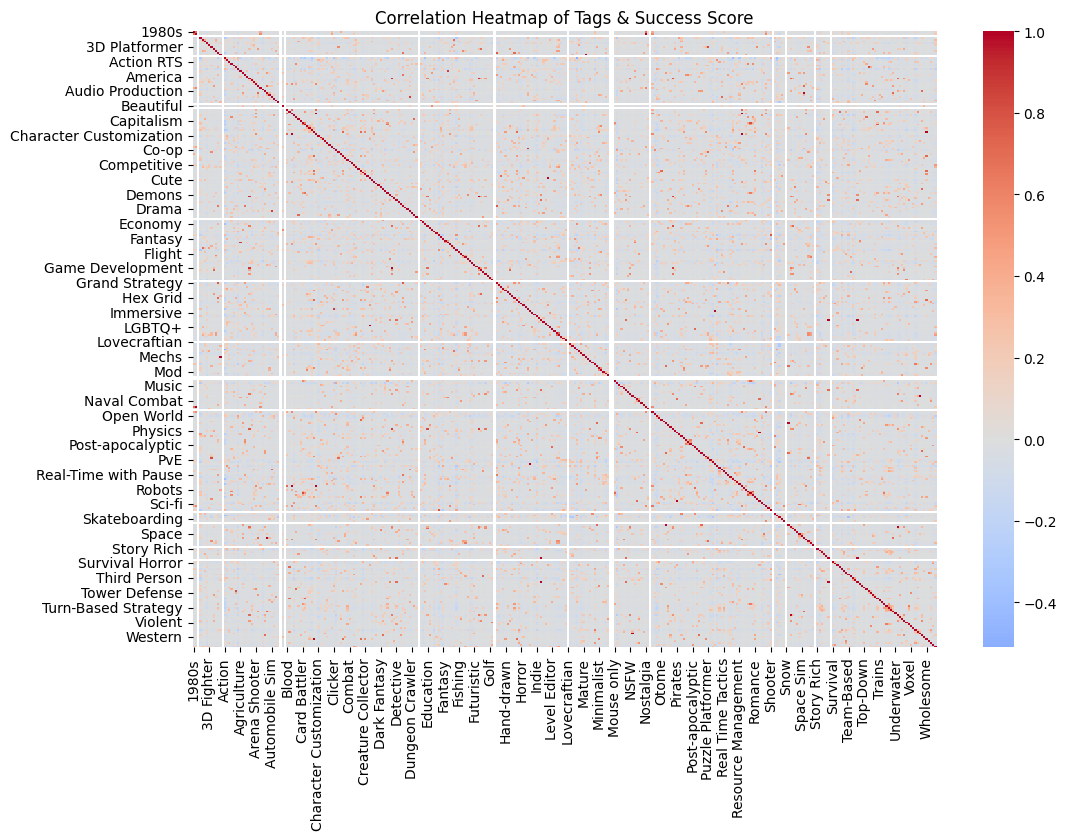

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = X.corr()

# Plot a heatmap to visualize correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Tags & Success Score')
plt.show()
